In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
#TY_features = pd.read_parquet(file_name_TY_features1)
TY_users = pd.read_parquet('C:/Users/vanee/OneDrive/Documents/statistics/TaoYin_User_Transactions.parquet')

In [3]:
# Calculate the 'profit' column using the formula (sum2 - sum1)
TY_users.loc[:,"profit"] = (TY_users["sum2"] - TY_users["sum1"])
TY_users.head()

,customer,invoice,invoice_date,artikelnr,volume,sum1,sum2,postcode_delivery,postcode_customer,channel,profit
0,2284,1187467,2020-01-02,6439980,24,343.73,362.30,80413,80413,Tel 86041,18.57
1,2284,1187467,2020-01-02,6439981,60,1067.64,1119.96,80413,80413,Tel 86041,52.32
2,2284,1187467,2020-01-02,6420905,120,2214.00,2408.40,80413,80413,Tel 86041,194.40
3,1704,1191447,2020-01-17,8433401,1,21.52,19.32,81724,81724,OTC 81812,-2.20
4,45,1187691,2020-01-03,7180136,4,28.91,28.49,81796,81796,Web Order,-0.42


In [4]:
TY_customer_merged = TY_users.groupby("customer").agg({'profit' : ['sum'], 'sum2' : ['sum']}).reset_index()
TY_customer_merged.head(10)

# Flatten the column index
TY_customer_merged.columns = ['_'.join(col).strip() for col in TY_customer_merged.columns.values]

# Rename sales column
TY_customer_merged = TY_customer_merged.rename(columns={'sum2_sum': 'sales_sum'})

# Display the DataFrame
print(TY_customer_merged.head(10))

   customer_  profit_sum   sales_sum
0          0       -2.53       13.72
1          3    10263.09   712214.87
2          4     -736.60     3135.02
3          5    -2220.25     2199.45
4          6       -8.89       99.48
5         14    33219.18  1397887.79
6         17    -1381.80      205.80
7         21       35.63      294.17
8         22     -126.29     1048.19
9         30       -8.49      289.87


In [5]:
column_sum1 = TY_customer_merged['profit_sum'].sum()
column_sum2 = TY_customer_merged['sales_sum'].sum()
print("Sum of Profit:", int(column_sum1))
print("Sum of Sales:", int(column_sum2))

Sum of Profit: 13312202
Sum of Sales: 127824304


Intermediate conclusion 1.1: The company is profitable with a margin of ~10%

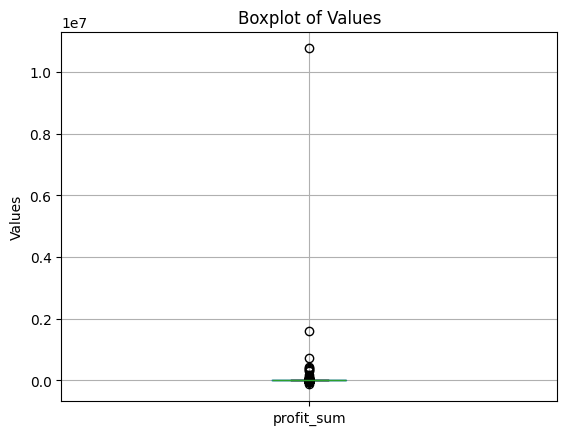

In [6]:
TY_customer_merged.boxplot(column='profit_sum')

# Labeling the axes
plt.title('Boxplot of Values')
plt.ylabel('Values')

# Show the plot
plt.show()

Intermediate conclusion 1.2: There are outliers which will distort my analysis. I need to take care of these outliers. 

In [7]:
# Extract the outliers
median = TY_customer_merged['profit_sum'].median()
mad = (TY_customer_merged['profit_sum'] - median).abs().median()

# Calculate modified Z-scores
TY_customer_merged['Modified Z-Score'] = 0.6745 * (TY_customer_merged['profit_sum'] - median) / mad

# Identify outliers
outliers = TY_customer_merged[TY_customer_merged['Modified Z-Score'].abs() > 3.5]

outlier_customers = outliers['customer_'].tolist()
# print(outlier_customers)
print("Outliers using Z-score:")
print(outliers)

Outliers using Z-score:
      customer_  profit_sum   sales_sum  Modified Z-Score
1             3    10263.09   712214.87         23.966517
3             5    -2220.25     2199.45         -4.621446
5            14    33219.18  1397887.79         76.538013
12           40    -2287.33    19653.09         -4.775065
14           42    -2465.45   104423.75         -5.182976
...         ...         ...         ...               ...
1060       2478    23093.03   149798.85         53.348226
1062       2486     6255.48    33897.85         14.788733
1064       2488     5513.15   224654.12         13.088731
1066       2492    -3160.73    15763.15         -6.775229
1069       2500   -13025.00    50832.34        -29.365288

[291 rows x 4 columns]


In [8]:
# Check if there are any infinite values in the margins_sum column
print(TY_customer_merged['profit_sum'].isin([np.inf, -np.inf]).sum())

# Replace infinite values with NaN
TY_customer_merged['profit_sum'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Optionally, fill NaN values with the maximum of the non-infinite data
TY_customer_merged['profit_sum'].fillna(TY_customer_merged['profit_sum'].max(), inplace=True)

0


C:\Users\vanee\AppData\Local\Temp\ipykernel_21568\1104076654.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  TY_customer_merged['profit_sum'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\vanee\AppData\Local\Temp\ipykernel_21568\1104076654.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [9]:
# Determine the min and max values of 'profit_sum' to create bins without the outliers
filtered_df = TY_customer_merged[~TY_customer_merged['customer_'].isin(outlier_customers)]
min_profit = filtered_df['profit_sum'].min()
max_profit = filtered_df['profit_sum'].max()

# Create evenly spaced bins for margins using min and max values
bins = np.linspace(min_profit, max_profit, num=6)  # Creates 5 equal-width intervals
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Create profit categories based on these equal-width bins
TY_customer_merged['profit_category'] = pd.cut(TY_customer_merged['profit_sum'], bins=bins, labels=labels, include_lowest=True)
TY_customer_merged.loc[TY_customer_merged['profit_sum'] > max_profit, 'profit_category'] = 'Very High' # bring the outliers back
TY_customer_merged.loc[TY_customer_merged['profit_sum'] < min_profit, 'profit_category'] = 'Very Low'  # bring the outliers back

# Sort by margin category and volume
sorted_df = TY_customer_merged.sort_values(by=['profit_category', 'sales_sum'], ascending=[True, False]).reset_index()

# Display the sorted dataframe
#print(sorted_df[['customer_', 'profit_sum', 'sales_sum', 'profit_category']].head(20))
sorted_df['profit_category'].value_counts()

profit_category
Medium       526
Very Low     286
Low          113
Very High     76
High          69
Name: count, dtype: int64

In [10]:
TY_customer_merged.head()

,customer_,profit_sum,sales_sum,Modified Z-Score,profit_category
0,0,-2.53,13.72,0.457331,Medium
1,3,10263.09,712214.87,23.966517,Very High
2,4,-736.60,3135.02,-1.223755,Low
3,5,-2220.25,2199.45,-4.621446,Very Low
4,6,-8.89,99.48,0.442766,Medium


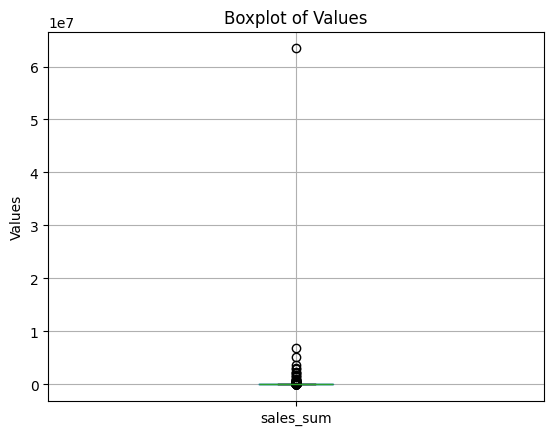

In [11]:
TY_customer_merged.boxplot(column='sales_sum')

# Labeling the axes
plt.title('Boxplot of Values')
plt.ylabel('Values')

# Show the plot
plt.show()

In [12]:
# Extract the outliers
median = TY_customer_merged['sales_sum'].median()
mad = (TY_customer_merged['sales_sum'] - median).abs().median()

# calculate modified z-scores
TY_customer_merged['Sales Z-Score'] = 0.6745 * (TY_customer_merged['sales_sum'] - median) / mad

# identify outliers
outliers = TY_customer_merged[TY_customer_merged['Sales Z-Score'].abs() > 3.5]

# get a list of customer ids that are outliers
outlier_customers = outliers['customer_'].tolist()

#print list of outliers
print("Outliers using Z-score:")
print(outliers)

Outliers using Z-score:
      customer_  profit_sum   sales_sum  Modified Z-Score profit_category  \
1             3    10263.09   712214.87         23.966517       Very High   
5            14    33219.18  1397887.79         76.538013       Very High   
10           34       82.02    82857.65          0.650958            High   
12           40    -2287.33    19653.09         -4.775065        Very Low   
14           42    -2465.45   104423.75         -5.182976        Very Low   
...         ...         ...         ...               ...             ...   
1052       2459   -13676.74    69836.86        -30.857831        Very Low   
1060       2478    23093.03   149798.85         53.348226       Very High   
1062       2486     6255.48    33897.85         14.788733       Very High   
1064       2488     5513.15   224654.12         13.088731       Very High   
1069       2500   -13025.00    50832.34        -29.365288        Very Low   

      Sales Z-Score  
1        181.743898  
5      

In [13]:
# Check if there are any infinite values in the margins_sum column
print(TY_customer_merged['sales_sum'].isin([np.inf, -np.inf]).sum())

# Replace infinite values with NaN
TY_customer_merged['sales_sum'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Optionally, fill NaN values with the maximum of the non-infinite data
TY_customer_merged['sales_sum'].fillna(TY_customer_merged['sales_sum'].max(), inplace=True)

0


C:\Users\vanee\AppData\Local\Temp\ipykernel_21568\3231130721.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  TY_customer_merged['sales_sum'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\vanee\AppData\Local\Temp\ipykernel_21568\3231130721.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [14]:
TY_customer_merged.head()

,customer_,profit_sum,sales_sum,Modified Z-Score,profit_category,Sales Z-Score
0,0,-2.53,13.72,0.457331,Medium,-0.700472
1,3,10263.09,712214.87,23.966517,Very High,181.743898
2,4,-736.60,3135.02,-1.223755,Low,0.099111
3,5,-2220.25,2199.45,-4.621446,Very Low,-0.140554
4,6,-8.89,99.48,0.442766,Medium,-0.678503


In [15]:
# Determine the min and max values of 'profit_sum' to create bins without the outliers
filtered_df = TY_customer_merged[~TY_customer_merged['customer_'].isin(outlier_customers)]
min_profit = filtered_df['sales_sum'].min()
max_profit = filtered_df['sales_sum'].max()

# Create evenly spaced bins for sales using min and max values
bins = np.linspace(min_profit, max_profit, num=6)  # Creates 5 equal-width intervals
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Create profit categories based on these equal-width bins
TY_customer_merged['sales_category'] = pd.cut(TY_customer_merged['sales_sum'], bins=bins, labels=labels, include_lowest=True)
TY_customer_merged.loc[TY_customer_merged['sales_sum'] > max_profit, 'sales_category'] = 'Very High' # bring the outliers back
TY_customer_merged.loc[TY_customer_merged['sales_sum'] < min_profit, 'sales_category'] = 'Very Low'  # bring the outliers back

# Sort by sales category and volume
sorted_df = TY_customer_merged.sort_values(by=['sales_category', 'sales_sum'], ascending=[True, False]).reset_index()

# Display the sorted dataframe
sorted_df['sales_category'].value_counts()
print(sorted_df[['customer_', 'profit_sum','profit_category','sales_sum', 'sales_category']].head(20))


    customer_  profit_sum profit_category  sales_sum sales_category
0        2473     -489.40          Medium    3272.79       Very Low
1        2133     -909.83             Low    3256.96       Very Low
2        1763     -395.94          Medium    3243.55       Very Low
3        1887    -4207.50        Very Low    3230.00       Very Low
4        2040     -445.39          Medium    3223.08       Very Low
5        2377       21.06          Medium    3217.90       Very Low
6         788     -211.76          Medium    3213.54       Very Low
7        1558    -1061.22             Low    3178.84       Very Low
8         287      240.07            High    3165.09       Very Low
9        2209      153.01            High    3160.30       Very Low
10        811    -1221.84        Very Low    3153.63       Very Low
11       1294       25.52          Medium    3148.57       Very Low
12          4     -736.60             Low    3135.02       Very Low
13       1384     -976.54             Low    311

In [16]:
# create new dataframe to one hot encode profit and sales columns
customers_features = TY_customer_merged[['customer_', 'profit_category', 'sales_category']].copy()

# one-hot encode profit and sales columns
customers_features = pd.get_dummies(customers_features, columns=['profit_category', 'sales_category'], prefix=['profit', 'sales'])

# convert boolean values to binary
customers_features = customers_features.astype(int)

# convert column names to lowercase and add underscore between words
customers_features.columns = customers_features.columns.str.replace(' ', '_').str.lower()

# print df head
customers_features.head()

,customer_,profit_very_low,profit_low,profit_medium,profit_high,profit_very_high,sales_very_low,sales_low,sales_medium,sales_high,sales_very_high
0,0,0,0,1,0,0,1,0,0,0,0
1,3,0,0,0,0,1,0,0,0,0,1
2,4,0,1,0,0,0,1,0,0,0,0
3,5,1,0,0,0,0,1,0,0,0,0
4,6,0,0,1,0,0,1,0,0,0,0


2. Clustering based on postcode

2.1 Customer clustering by postcode

In [17]:
# group customers by postcode while counting the number of customers in each postcode
customers_by_postcode = TY_users.groupby('postcode_customer')['customer'].nunique().reset_index()

# rename column
customers_by_postcode.columns = ['postcode_customer','customer_count']

# sort by customer count
customers_by_postcode_sorted = customers_by_postcode.sort_values(by='customer_count', ascending=False)

# print result
print(customers_by_postcode_sorted.head(20))

     postcode_customer  customer_count
366              85705              27
477              87547              21
549              89206              18
74               81704              12
550              89207              12
393              86041              11
108              81812              10
69               81689               9
544              89201               9
458              87500               8
178              83047               8
90               81747               7
266              84817               7
394              86042               7
560              89247               7
468              87532               6
73               81703               6
475              87545               6
456              87482               6
135              82031               6


In [18]:
customers_by_postcode_sorted.head()

,postcode_customer,customer_count
366,85705,27
477,87547,21
549,89206,18
74,81704,12
550,89207,12


In [19]:
# Get unique values from 'postcode_customer' column
count_customer_postcode = TY_users['postcode_customer'].nunique()

# Print count of unique values
print(count_customer_postcode)

593


2.1.1. Performing a DBScan to find the customer clusters around the postcodes

In [20]:
# scaling the customer count
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customers_by_postcode_sorted[['customer_count']])

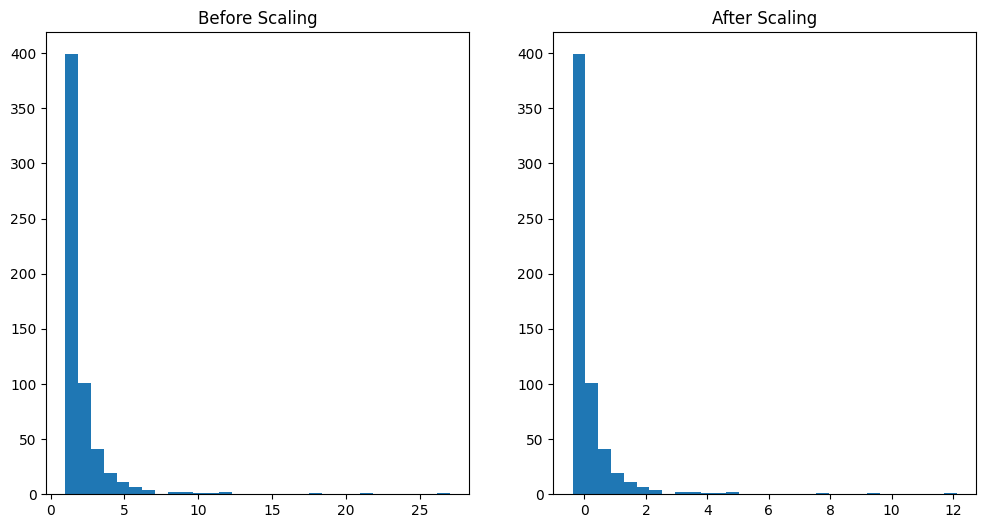

In [21]:
# plotting before and after scaling
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(customers_by_postcode_sorted['customer_count'], bins=30)
ax[0].set_title('Before Scaling')
ax[1].hist(X_scaled, bins=30)
ax[1].set_title('After Scaling')
plt.show()

In [22]:
# Scale the customer count
scaler = StandardScaler()
X_scaled_robust = scaler.fit_transform(customers_by_postcode_sorted[['customer_count']])

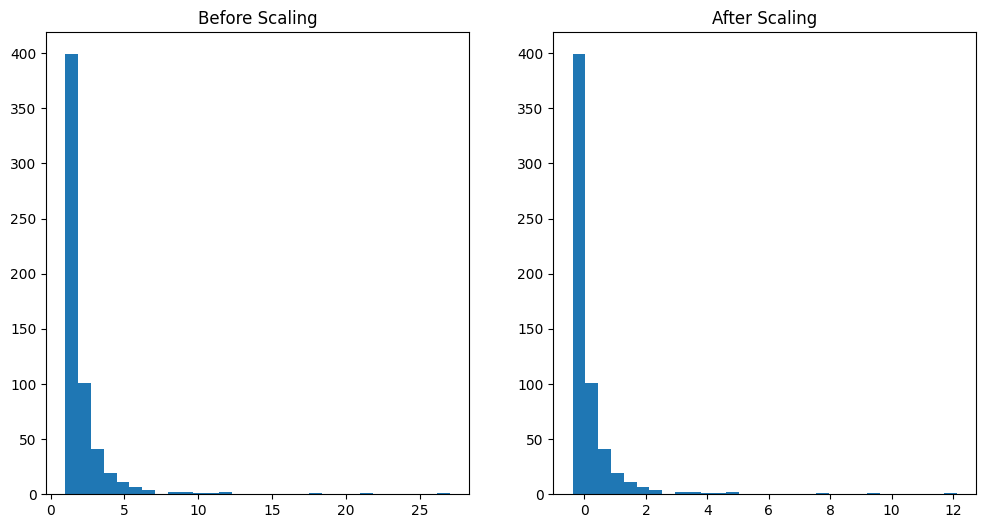

In [23]:
# Plotting before and after scaling
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(customers_by_postcode_sorted['customer_count'], bins=30)
ax[0].set_title('Before Scaling')
ax[1].hist(X_scaled_robust, bins=30)
ax[1].set_title('After Scaling')
plt.show()

In [24]:
# initializing DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=2)

# Fit DBSCAN to the scaled data and add the cluster labels to the DataFrame
customers_by_postcode_sorted['cluster_dbscan'] = dbscan.fit_predict(X_scaled)

# Print postcodes that are part of clusters (not noise)
print(customers_by_postcode_sorted[customers_by_postcode_sorted['cluster_dbscan'] != -1])

     postcode_customer  customer_count  cluster_dbscan
74               81704              12               0
550              89207              12               0
69               81689               9               1
544              89201               9               1
458              87500               8               2
..                 ...             ...             ...
582              89686               1               9
581              89636               1               9
580              89625               1               9
579              89615               1               9
578              89611               1               9

[588 rows x 3 columns]


In [25]:
# Get cluster labels
labels = dbscan.labels_

# Add labels to the original df
customers_by_postcode_sorted['cluster_dbscan'] = labels

# Number of clusters, excluding noise (-1 label)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'Estimated number of clusters: {num_clusters}')

# Number of noise points
num_noise_points = list(labels).count(-1)
print(f'Estimated number of noise points: {num_noise_points}')

Estimated number of clusters: 10
Estimated number of noise points: 5


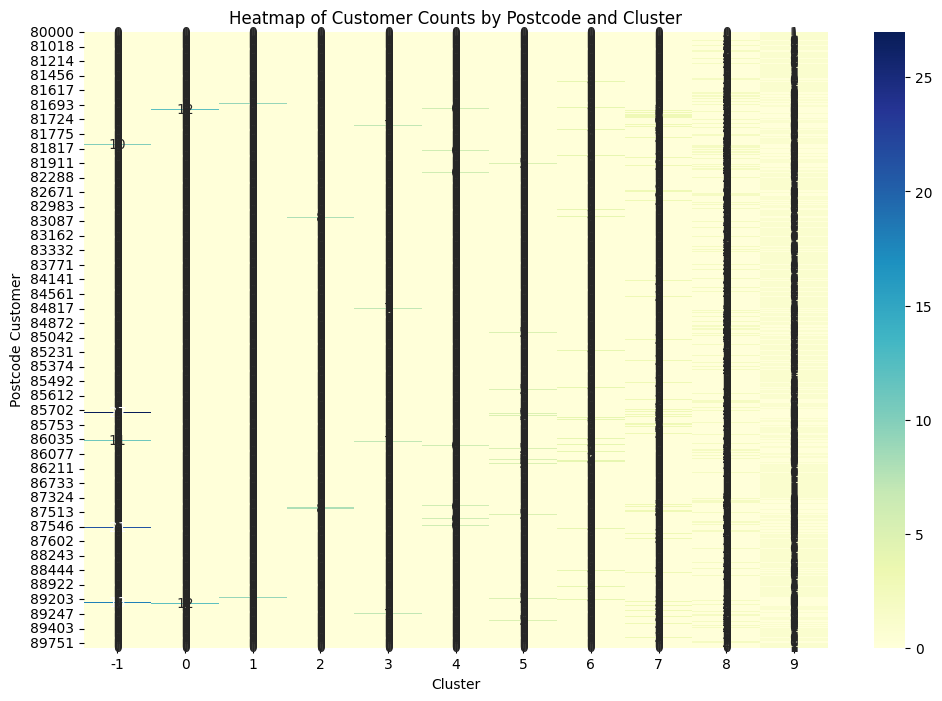

In [26]:
# Create a pivot table for heatmap
heatmap_data = customers_by_postcode_sorted.pivot_table(values='customer_count', index='postcode_customer', columns='cluster_dbscan', fill_value=0)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='g')
plt.title('Heatmap of Customer Counts by Postcode and Cluster')
plt.xlabel('Cluster')
plt.ylabel('Postcode Customer')
plt.show()

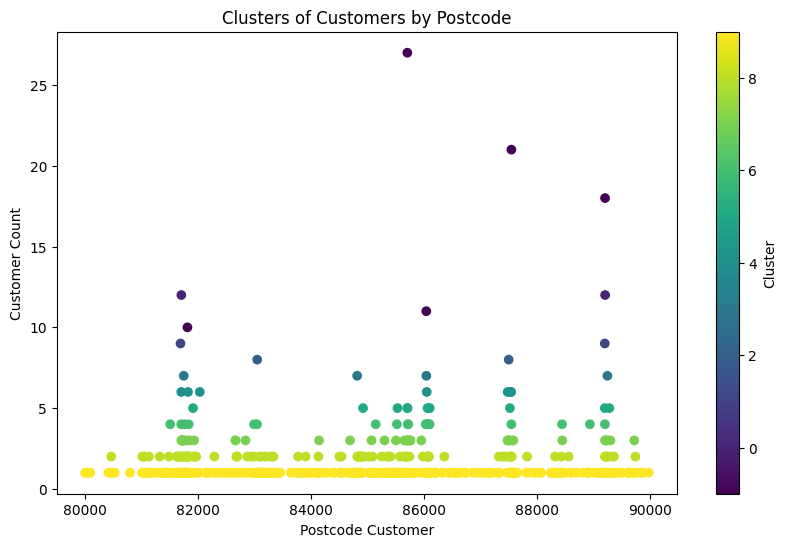

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(customers_by_postcode_sorted['postcode_customer'], customers_by_postcode_sorted['customer_count'], c=customers_by_postcode_sorted['cluster_dbscan'], cmap='viridis')
plt.title('Clusters of Customers by Postcode')
plt.xlabel('Postcode Customer')
plt.ylabel('Customer Count')
plt.colorbar(label='Cluster')
plt.show()

In [28]:
# Grouping by cluster and collecting postcodes
postcodes_per_cluster = customers_by_postcode_sorted.groupby('cluster_dbscan')['postcode_customer'].apply(list).reset_index()

# Display the postcodes in each cluster
print(postcodes_per_cluster)

    cluster_dbscan                                  postcode_customer
0               -1                [85705, 87547, 89206, 86041, 81812]
1                0                                     [81704, 89207]
2                1                                     [81689, 89201]
3                2                                     [87500, 83047]
4                3                       [81747, 84817, 86042, 89247]
5                4  [87532, 81703, 87545, 87482, 82031, 86049, 81822]
6                5  [86093, 81911, 85708, 86063, 86101, 89281, 892...
7                6  [88444, 81761, 86097, 86095, 86031, 85711, 857...
8                7  [81705, 81713, 87483, 81716, 87511, 87481, 875...
9                8  [89204, 87825, 89351, 89363, 81483, 81693, 817...
10               9  [80000, 89979, 80023, 80036, 80085, 80088, 804...


In [29]:
# Summary of clusters with customer counts and postcodes
cluster_summary = customers_by_postcode_sorted.groupby('cluster_dbscan').agg({
    'postcode_customer': lambda x: list(x),  # List of postcodes in the cluster
    'customer_count': 'sum'  # Total customer count for the cluster
}).reset_index()

# Rename the columns for clarity
cluster_summary.columns = ['cluster_dbscan', 'postcodes', 'total_customers']

# Display the summary
print(cluster_summary)

    cluster_dbscan                                          postcodes  \
0               -1                [85705, 87547, 89206, 86041, 81812]   
1                0                                     [81704, 89207]   
2                1                                     [81689, 89201]   
3                2                                     [87500, 83047]   
4                3                       [81747, 84817, 86042, 89247]   
5                4  [87532, 81703, 87545, 87482, 82031, 86049, 81822]   
6                5  [86093, 81911, 85708, 86063, 86101, 89281, 892...   
7                6  [88444, 81761, 86097, 86095, 86031, 85711, 857...   
8                7  [81705, 81713, 87483, 81716, 87511, 87481, 875...   
9                8  [89204, 87825, 89351, 89363, 81483, 81693, 817...   
10               9  [80000, 89979, 80023, 80036, 80085, 80088, 804...   

    total_customers  
0                87  
1                24  
2                18  
3                16  
4            

C:\Users\vanee\AppData\Local\Temp\ipykernel_21568\941129978.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_summary, x='cluster_dbscan', y='total_customers', palette='viridis')


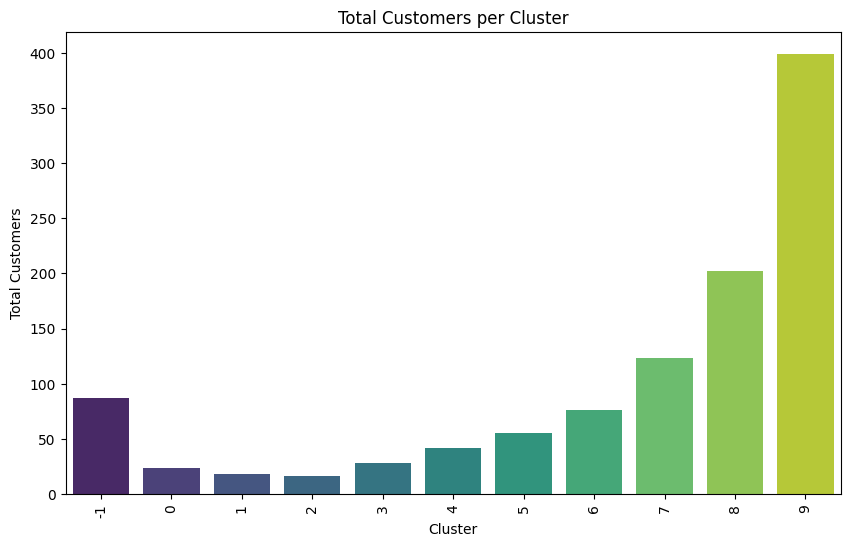

In [30]:
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_summary, x='cluster_dbscan', y='total_customers', palette='viridis')
plt.title('Total Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Customers')
plt.xticks(rotation=90)
plt.show()

In [31]:
customers_by_postcode_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 593 entries, 366 to 578
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   postcode_customer  593 non-null    int64
 1   customer_count     593 non-null    int64
 2   cluster_dbscan     593 non-null    int64
dtypes: int64(3)
memory usage: 18.5 KB


In [32]:
customers_by_postcode_sorted.head(10)

,postcode_customer,customer_count,cluster_dbscan
366,85705,27,-1
477,87547,21,-1
549,89206,18,-1
74,81704,12,0
550,89207,12,0
393,86041,11,-1
108,81812,10,-1
69,81689,9,1
544,89201,9,1
458,87500,8,2


2.1.2 Performing K-means to cluster customers by postcode

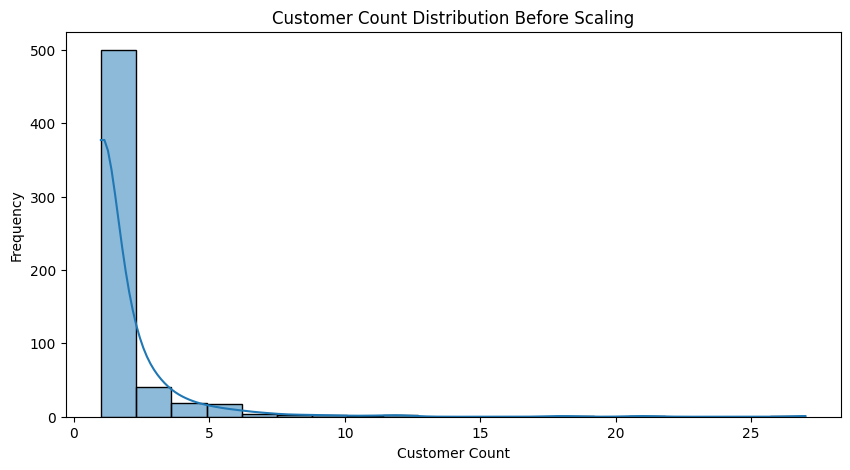

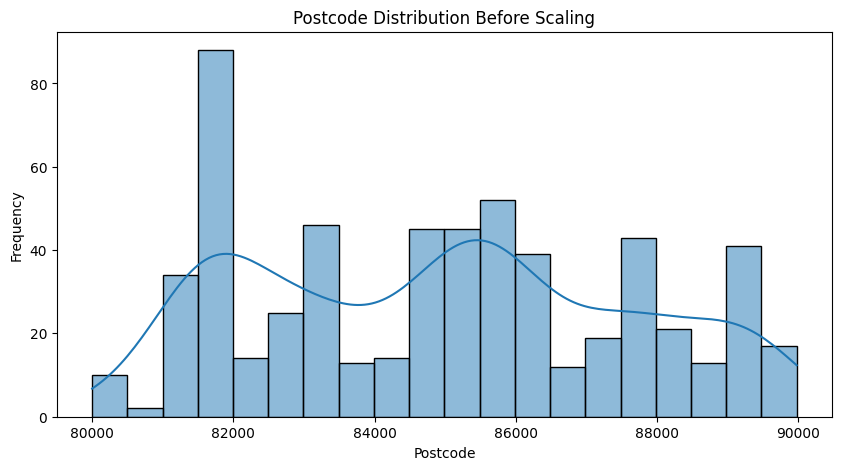

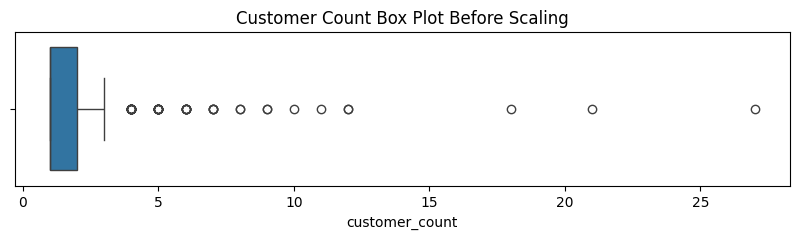

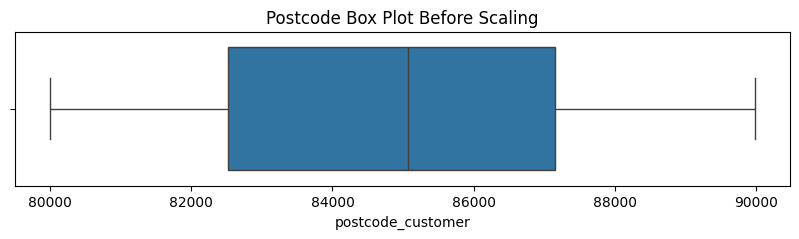

In [33]:
# Histogram for customer count before scaling
plt.figure(figsize=(10, 5))
sns.histplot(customers_by_postcode['customer_count'], bins=20, kde=True)
plt.title("Customer Count Distribution Before Scaling")
plt.xlabel("Customer Count")
plt.ylabel("Frequency")
plt.show()

# Histogram for postcode before scaling
plt.figure(figsize=(10, 5))
sns.histplot(customers_by_postcode['postcode_customer'], bins=20, kde=True)
plt.title("Postcode Distribution Before Scaling")
plt.xlabel("Postcode")
plt.ylabel("Frequency")
plt.show()

# Box plot for customer count before scaling
plt.figure(figsize=(10, 2))
sns.boxplot(x=customers_by_postcode['customer_count'])
plt.title("Customer Count Box Plot Before Scaling")
plt.show()

# Box plot for postcode before scaling
plt.figure(figsize=(10, 2))
sns.boxplot(x=customers_by_postcode['postcode_customer'])
plt.title("Postcode Box Plot Before Scaling")
plt.show()

In [34]:
# selecting features for k-means
X_kmeans = customers_by_postcode[['postcode_customer', 'customer_count']].values

In [35]:
# scaling & fit_transform the data 
scaler = StandardScaler()
X_scaled_kmeans = scaler.fit_transform(X_kmeans)

# Add scaled columns individually to the DataFrame
customers_by_postcode_scaled = customers_by_postcode.copy()
customers_by_postcode_scaled['postcode_scaled'] = X_scaled_kmeans[:, 0]  # Scaled postcode_customer
customers_by_postcode_scaled['customer_count_scaled'] = X_scaled_kmeans[:, 1]  # Scaled customer_count

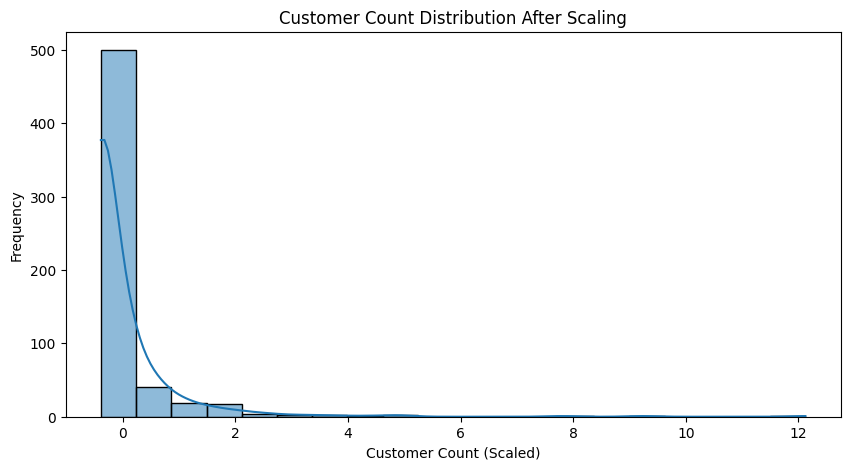

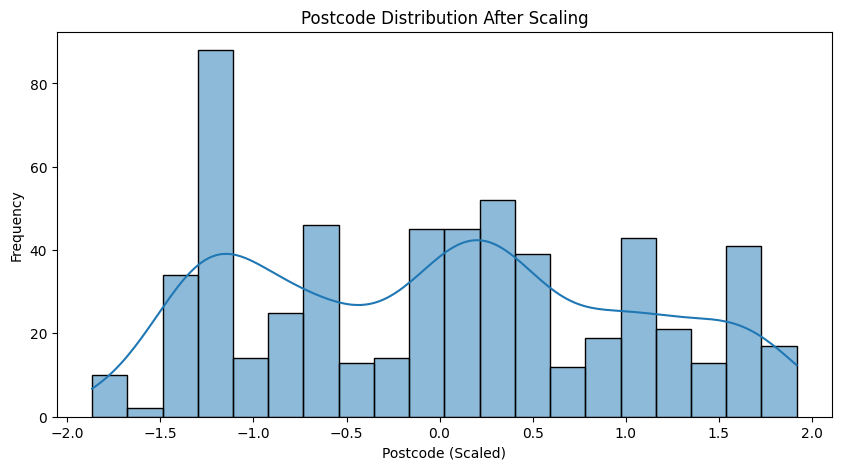

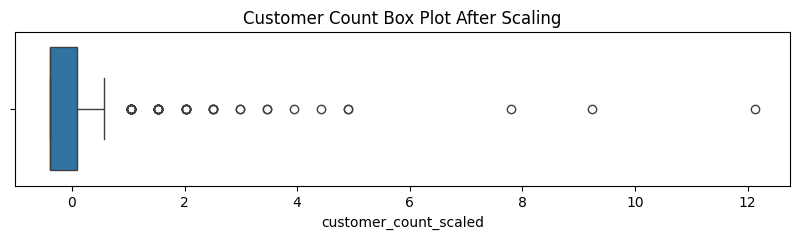

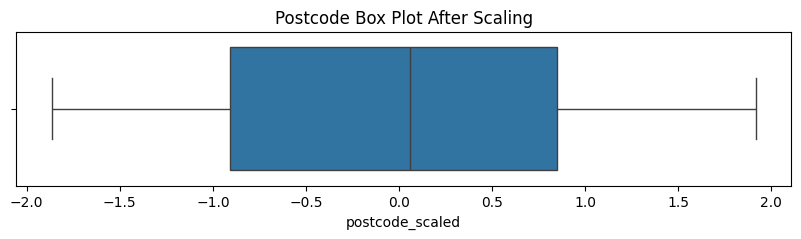

In [36]:
# Histogram to check customer_count distribution after scaling
plt.figure(figsize=(10, 5))
sns.histplot(customers_by_postcode_scaled['customer_count_scaled'], bins=20, kde=True)
plt.title("Customer Count Distribution After Scaling")
plt.xlabel("Customer Count (Scaled)")
plt.ylabel("Frequency")
plt.show()

# Histogram to check postcode distribution after scaling
plt.figure(figsize=(10, 5))
sns.histplot(customers_by_postcode_scaled['postcode_scaled'], bins=20, kde=True)
plt.title("Postcode Distribution After Scaling")
plt.xlabel("Postcode (Scaled)")
plt.ylabel("Frequency")
plt.show()

# Box plot for customer_count after scaling
plt.figure(figsize=(10, 2))
sns.boxplot(x=customers_by_postcode_scaled['customer_count_scaled'])
plt.title("Customer Count Box Plot After Scaling")
plt.show()

# Box plot for postcode after scaling
plt.figure(figsize=(10, 2))
sns.boxplot(x=customers_by_postcode_scaled['postcode_scaled'])
plt.title("Postcode Box Plot After Scaling")
plt.show()

In [37]:
# Check mean and standard deviation of the scaled data for customer count
mean_customer_count = customers_by_postcode_scaled['customer_count_scaled'].mean()  # should be close to 0
std_dev_customer_count = customers_by_postcode_scaled['customer_count_scaled'].std()  # should be close to 1

print(f"Mean after scaling for customer count: {mean_customer_count}")
print(f"Standard deviation after scaling for customer count: {std_dev_customer_count}")

# Check mean and standard deviation of the scaled data for postcode
mean_postcode = customers_by_postcode_scaled['postcode_scaled'].mean()  # should be close to 0
std_dev_postcode = customers_by_postcode_scaled['postcode_scaled'].std()  # should be close to 1

print(f"Mean after scaling for postcode: {mean_postcode}")
print(f"Standard deviation after scaling for postcode: {std_dev_postcode}")

Mean after scaling for customer count: -4.7928683693767295e-17
Standard deviation after scaling for customer count: 1.0008442382255038
Mean after scaling for postcode: 2.252648133607063e-15
Standard deviation after scaling for postcode: 1.0008442382255038


Interpretation of results:

Because the mean is close to 0 and the standard deviation is very close to 1 for both features, it means that the data is correctly scaled and ready to cluster using K-means. 

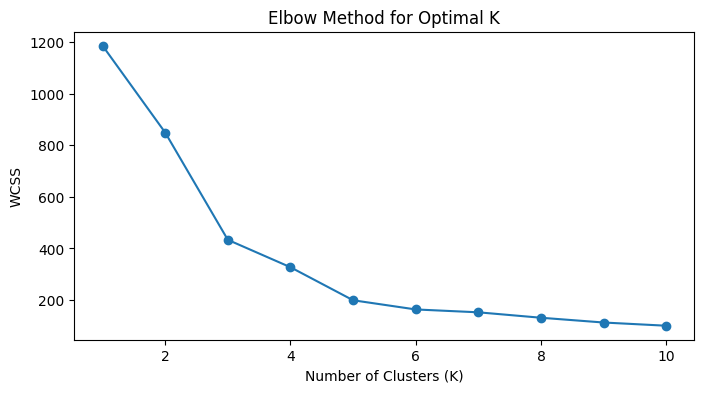

In [38]:
wcss = [] # empty list to store WCSS for each k-value

# test values 1-10 for K
for k in range (1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0) # setting the number of clusters
    kmeans.fit(X_scaled_kmeans) # fit k-means model
    wcss.append(kmeans.inertia_) # append wcss to list

# plot wcss values to find the elbow
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

Applying K-means clustering with K=3

In [39]:
# Setting K to the chosen value
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
clusters = kmeans.fit_predict(X_scaled_kmeans)  # Fit and predict cluster labels

# Add cluster labels to your original DataFrame for analysis
customers_by_postcode['cluster_1'] = clusters

Applying K-means clustering with K=4

In [40]:
# Set K to the chosen value (e.g., 4 if the elbow suggests this)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
clusters = kmeans.fit_predict(X_scaled_kmeans)  # Fit and predict cluster labels

# Add cluster labels to your original DataFrame for analysis
customers_by_postcode['cluster_2'] = clusters

In [41]:
print("WCSS for K=3:", wcss[2])  # WCSS for 3 clusters
print("WCSS for K=4:", wcss[3])  # WCSS for 4 clusters

WCSS for K=3: 433.2224356599355
WCSS for K=4: 326.93654508385345


Based on the WCSS above, K=4 has better cohesion within the clusters.

Next, we will be calculating the silhouette score for K=3 and K=4 to compare which value provides better separation of data.

In [42]:
# fit KMeans for K=3
kmeans_3 = KMeans(n_clusters=3, random_state=42)
y_kmeans_3 = kmeans_3.fit_predict(X_scaled_kmeans) # fit and predict clusters

# fit KMeans for K=4
kmeans_4 = KMeans(n_clusters=4,random_state=42)
y_kmeans_4 = kmeans_4.fit_predict(X_scaled_kmeans) # fit & predict clusters

# calculate silhouette score for K=3
silhouette_score_3 = silhouette_score(X_scaled_kmeans, y_kmeans_3)
print(f'Silhouette score for K=3: {silhouette_score_3}')

# calculate silhouette score for K=4
silhouette_score_4 = silhouette_score(X_scaled_kmeans, y_kmeans_4)
print(f'Silhouette score for K=4: {silhouette_score_4}')

Silhouette score for K=3: 0.4146853372650743
Silhouette score for K=4: 0.483383038531568


Since both silhouette scores are quite low, we will calculated the silhouette score for K in the range 5 to 10. The results start to fluctuate after K=5, by constantly decreasing and slightly increasing. This indicates that additional clusters may not provide improvements. Thus, K=5 is the optimal number of clusters.

In [43]:
# fit KMeans for K=5
kmeans_5 = KMeans(n_clusters=5, random_state=42)
y_kmeans_5 = kmeans_5.fit_predict(X_scaled_kmeans)  # fit & predict clusters

# calculate silhouette score for K=10
silhouette_score_5 = silhouette_score(X_scaled_kmeans, y_kmeans_5)
print(f'Silhouette score for K=5: {silhouette_score_5}')

Silhouette score for K=5: 0.512742010320806


In [44]:
customers_by_postcode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   postcode_customer  593 non-null    int64
 1   customer_count     593 non-null    int64
 2   cluster_1          593 non-null    int32
 3   cluster_2          593 non-null    int32
dtypes: int32(2), int64(2)
memory usage: 14.0 KB


In [45]:
# Dropping columns 'cluster_1' and 'cluster_2'
customers_by_postcode = customers_by_postcode.drop(columns=['cluster_1', 'cluster_2'])
customers_by_postcode.head()

,postcode_customer,customer_count
0,80000,1
1,80016,1
2,80023,1
3,80036,1
4,80085,1


In [ ]:
# Adding cluster labels to the df for analysis
customers_by_postcode['cluster'] = clusters

# Summarizing the number of customers per cluster
cluster_summary = customers_by_postcode['cluster'].value_counts().sort_index()
print(cluster_summary)

cluster
0    215
1      9
2    217
3    152
Name: count, dtype: int64


In [49]:
# Get cluster centers
cluster_centers_k5 = kmeans_5.cluster_centers_

# Create DataFrame to view the cluster centers
cluster_centers_df = pd.DataFrame(cluster_centers_k5, columns=['customer_count', 'postcode_customer'])
print(cluster_centers_df)

   customer_count  postcode_customer
0        0.129619          -0.234838
1        1.321240          -0.196582
2       -1.090386          -0.178538
3        0.973159           9.717476
4        0.259941           2.066911


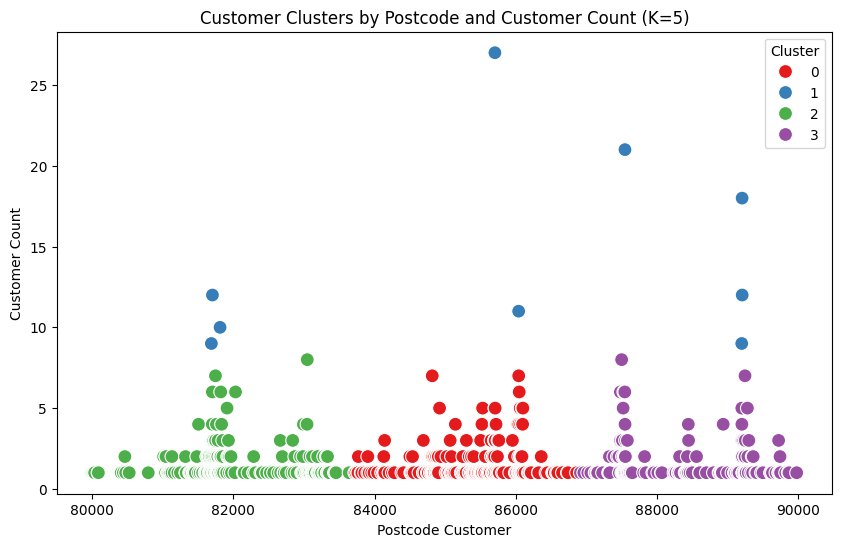

In [50]:
# Visualizing clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customers_by_postcode, x='postcode_customer', y='customer_count', hue='cluster', palette='Set1', marker='o', s=100)
plt.title('Customer Clusters by Postcode and Customer Count (K=5)')
plt.xlabel('Postcode Customer')
plt.ylabel('Customer Count')
plt.legend(title='Cluster', loc='upper right')
plt.show()

Based on the visualization, cluster 1 seems to represent outliers.

In [51]:
# Filter out the data for Cluster 1
cluster_1_data = customers_by_postcode[customers_by_postcode['cluster'] == 1]

# Get a statistical summary for Cluster 1
cluster_1_summary = cluster_1_data[['customer_count', 'postcode_customer']].describe()
print(cluster_1_summary)

       customer_count  postcode_customer
count        9.000000           9.000000
mean        14.333333       85790.222222
std          6.284903        3306.720837
min          9.000000       81689.000000
25%         10.000000       81812.000000
50%         12.000000       86041.000000
75%         18.000000       89201.000000
max         27.000000       89207.000000


2.2 Article clustering by postcode